In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# from dataset import MARSDataset
# from model import *

from test_helper import *

from scipy.spatial.distance import cdist
from matplotlib import gridspec

import os 
import textwrap as tw

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
# # train_dataset = combine_dataset(batch_size=32, image_size=[256, 128], same_prob=0.95, diff_prob=.001, train=True)
# val_dataset = combine_dataset(batch_size=1, image_size=[256, 128], same_prob=0.5, diff_prob=0.5, train=False)
# handle = tf.placeholder(tf.string, shape=[])

# iterator = tf.data.Iterator.from_string_handle(
#             handle, val_dataset.output_types, val_dataset.output_shapes)

# # train_iterator = train_dataset.make_one_shot_iterator()
# val_iterator = val_dataset.make_one_shot_iterator()
# 
# left, right = iterator.get_next()
# left_input_im, left_label, left_addr = left
# right_input_im, right_label, right_addr = right

left_input_im = tf.placeholder(tf.float32, [None, 256, 128, 3], 'left_input_im')
right_input_im = tf.placeholder(tf.float32, [None, 256, 128, 3], 'right_input_im')
left_label = tf.placeholder(tf.float32, [None, ], 'left_label')
right_label = tf.placeholder(tf.float32, [None, ], 'right_label')

# batch_y = (left_label == right_label)

print(np.shape(left_input_im), np.shape(right_input_im))
logits, model_left, model_right = inference(left_input_im, right_input_im)
# loss(logits, left_label, right_label)
# label_float = tf.to_float(left_label)
# contrastive_loss(model_left, model_right, logits, left_label, right_label, margin=0.2, use_loss=True)
# triplet_loss(model_left, model_left, model_right, 0.5, use_loss=True)

# total_loss = tf.losses.get_total_loss()
global_step = tf.Variable(0, trainable=False)

# params = tf.trainable_variables()
# gradients = tf.gradients(total_loss, params)

# optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
# updates = optimizer.apply_gradients(zip(gradients, params), global_step=global_step)

# updates = tf.train.MomentumOptimizer(0.01, 0.99, use_nesterov=True).minimize(loss, global_step=global_step)

global_init = tf.variables_initializer(tf.global_variables())

(?, 256, 128, 3) (?, 256, 128, 3)
(?, 256, 128, 3)
(?, 256, 128, 256)
(?, 128, 64, 256)
(?, 128, 64, 128)
(?, 64, 32, 128)
(?, 64, 32, 64)
(?, 32, 16, 64)
(?, 32, 16, 32)
(?, 16, 8, 32)
(?, 4096)
(?, 4096)
(?, 256, 128, 3)
(?, 256, 128, 256)
(?, 128, 64, 256)
(?, 128, 64, 128)
(?, 64, 32, 128)
(?, 64, 32, 64)
(?, 32, 16, 64)
(?, 32, 16, 32)
(?, 16, 8, 32)
(?, 4096)
(?, 4096)


INFO:tensorflow:Restoring parameters from model_siamese/epoch_5/model.ckpt


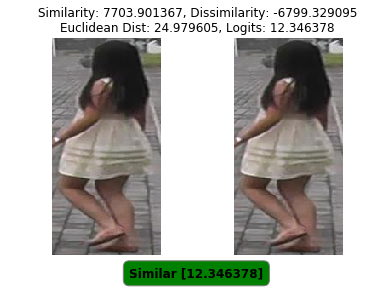

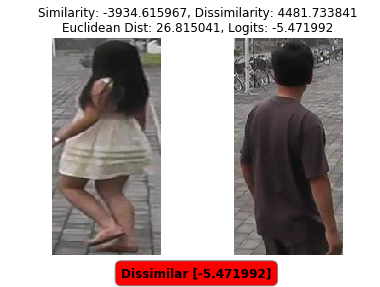

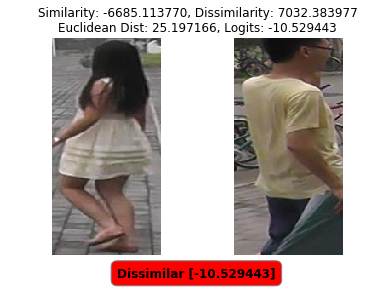

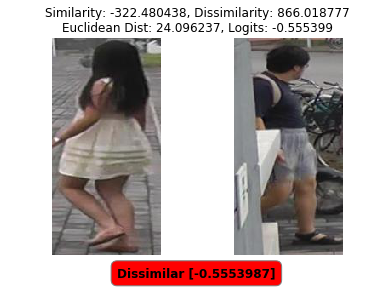

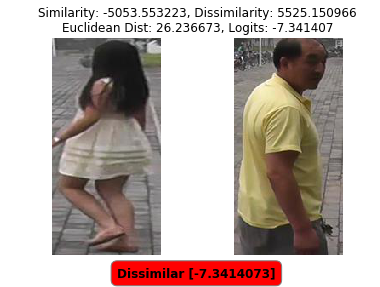

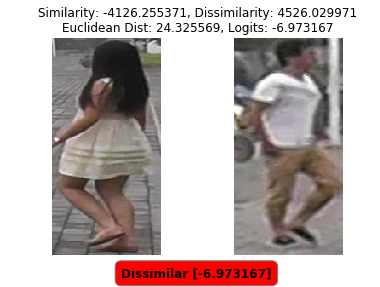

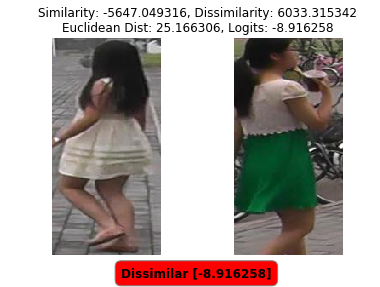

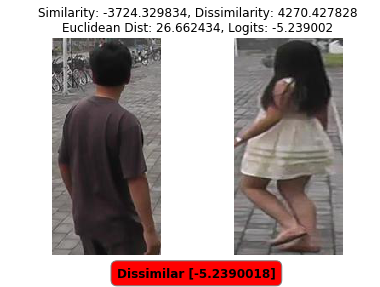

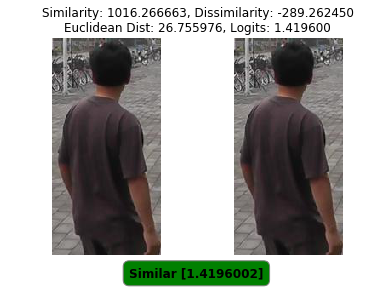

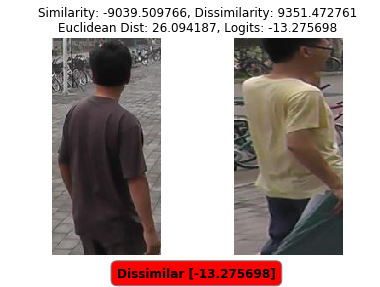

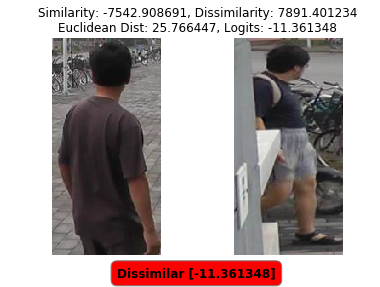

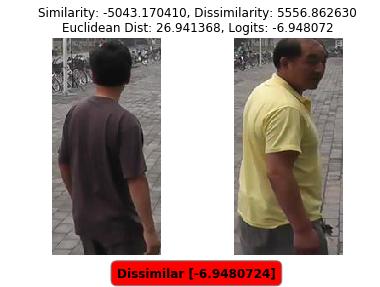

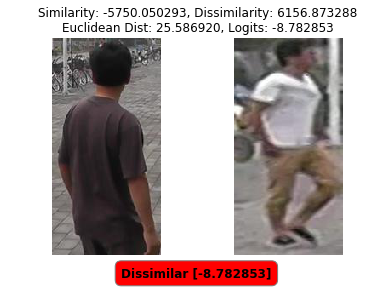

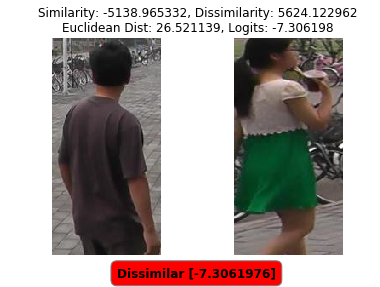

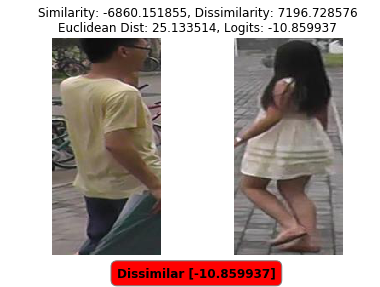

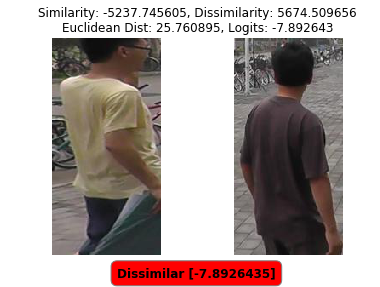

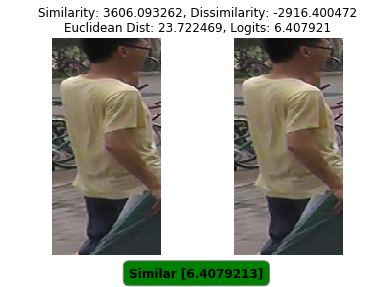

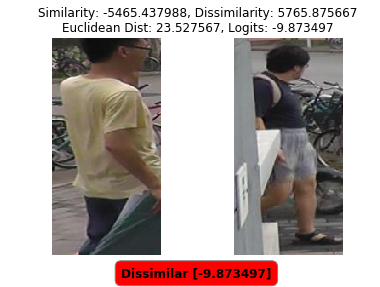

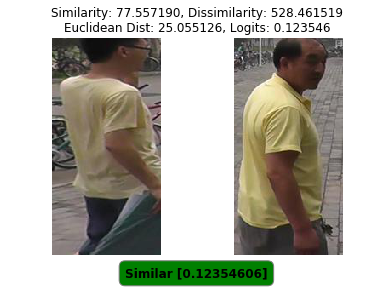

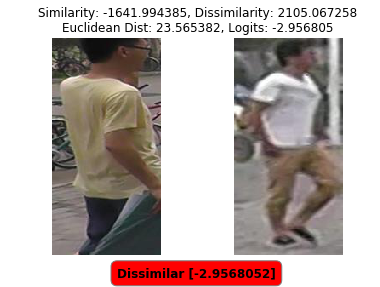

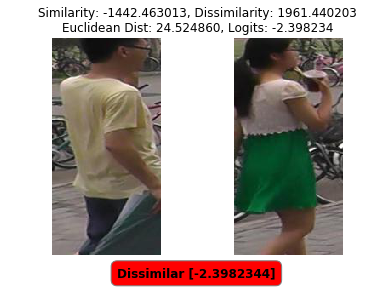

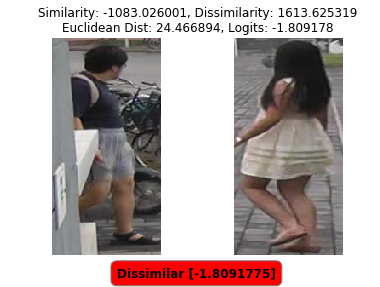

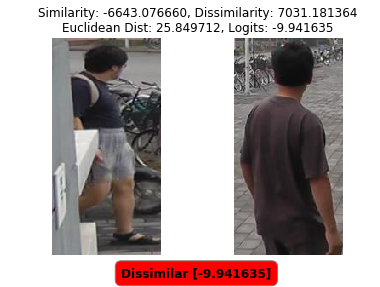

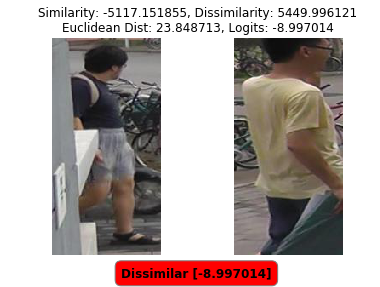

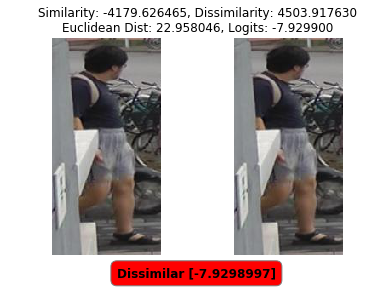

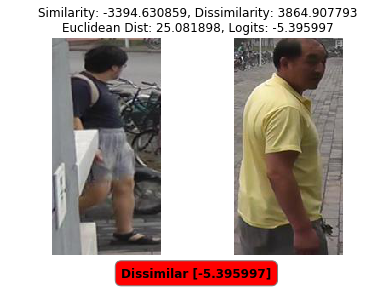

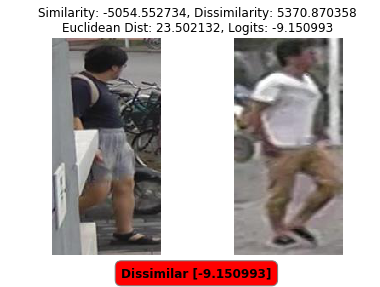

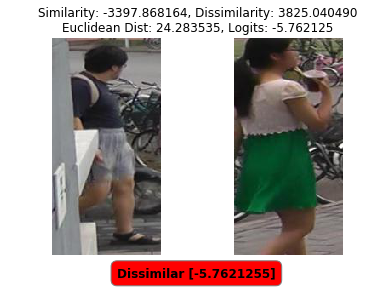

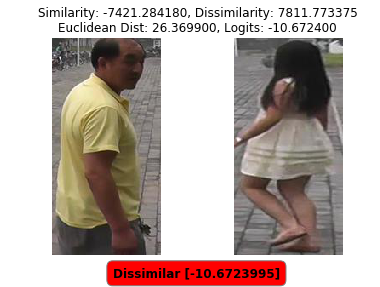

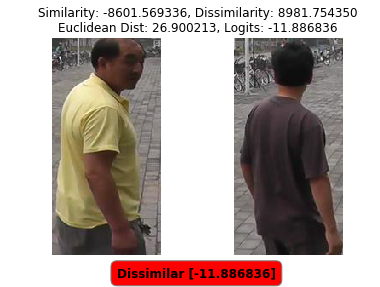

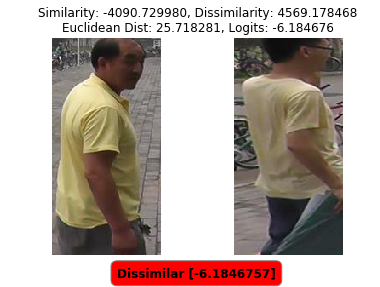

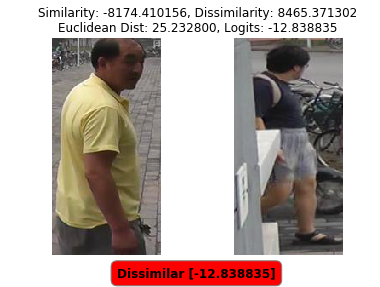

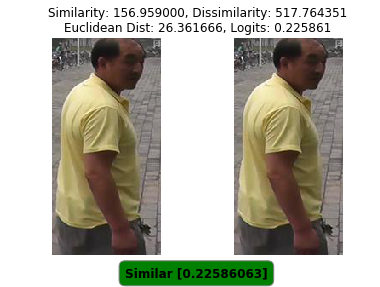

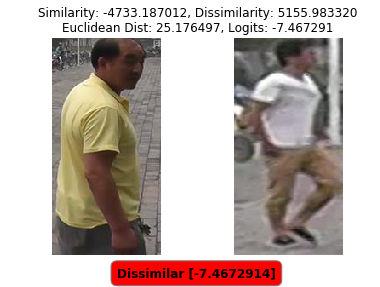

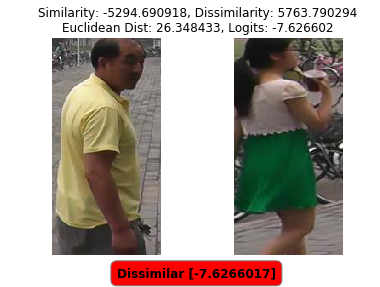

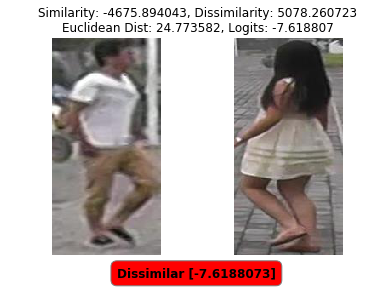

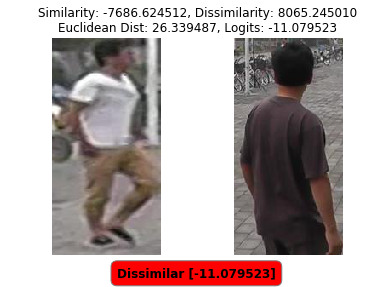

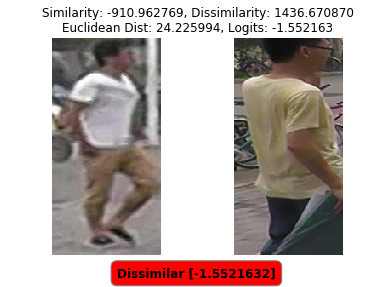

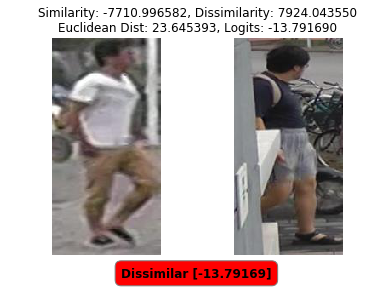

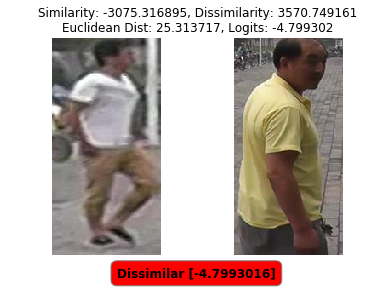

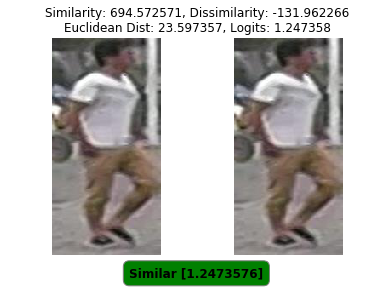

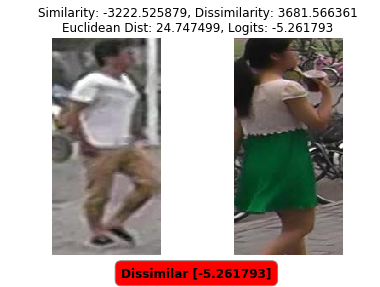

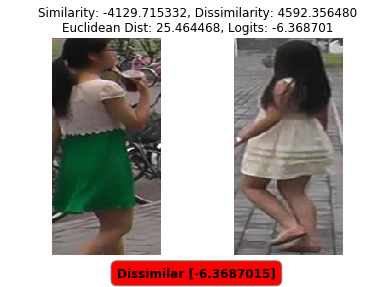

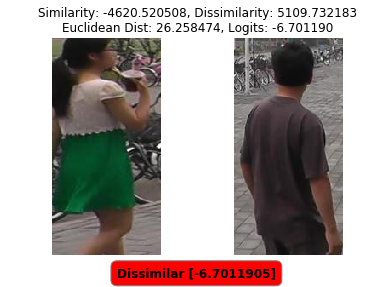

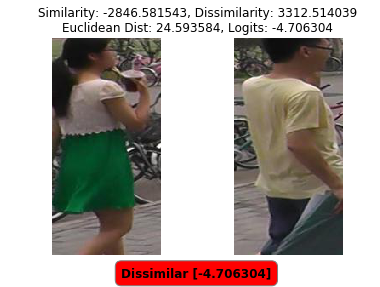

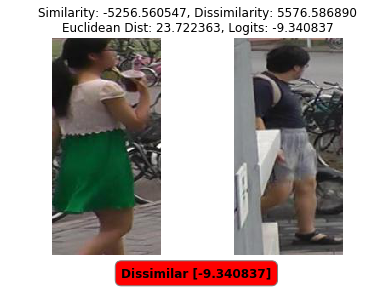

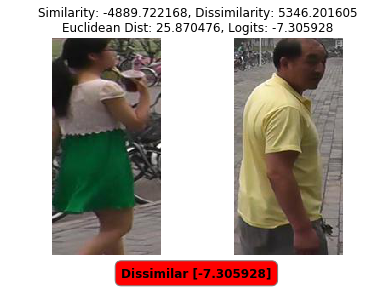

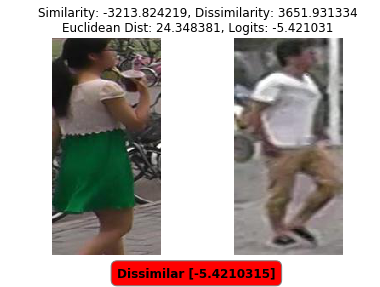

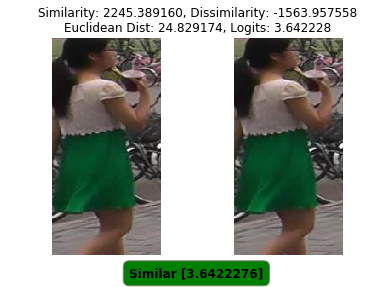

In [3]:
from PIL import Image




# fig = plt.figure()
# ax = fig.add_subplot(1,2,1)
# l_im = np.array(img)[0]
# ax.imshow(l_im)
# ax = fig.add_subplot(1,2,2)
# r_im = np.array(img2)[0]
# ax.imshow(r_im)
# ax.axis('off')
# plt.show()

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(global_init)
    ckpt = tf.train.get_checkpoint_state("model")
#     saver.restore(sess, "model_siamese/model.ckpt")
    saver.restore(sess, "model_siamese/epoch_5/model.ckpt")

#     validation_handle = sess.run(val_iterator.string_handle())
#     feed_dict_val = {handle:validation_handle}

    for im1 in range(1,8):
        for im2 in range(1,8):


            img = Image.open(str(im1) + '.jpg')
            img = np.array(img)[np.newaxis,:,:,:] #/ 255.0
            # img2 = img
            img2 = Image.open(str(im2) + '.jpg')
            img2 = np.array(img2)[np.newaxis,:,:,:] #/ 255.0


            my_logits, model_lf, model_rg = sess.run([logits, model_left, model_right], \
                                                     feed_dict={left_input_im:img, right_input_im:img2})

#             print(my_logits)
#             print(np.shape(model_lf))
#             print(np.shape(model_rg))

            lft = np.array(model_lf[0])
            rgt = np.array(model_rg[0])
            l = lft - rgt

            distance = np.sqrt(np.sum((l) ** 2))
            similarity = my_logits * np.square(distance)  # keep the similar label (1) close to each other
            dissimilarity = (1 - np.array(my_logits[0])) * np.square(np.max((0.5 - distance),
                                                           0))  # give penalty to dissimilar label if the distance is bigger than margin
            similarity_loss = np.mean(dissimilarity + similarity) / 2
#             print('distance : ', distance)
#             print('similarity : ', similarity)
#             print('dissimilarity : ', dissimilarity)
#             print('similarity_loss : ', similarity_loss)

            dist = cdist(model_lf, model_rg, 'cosine')
#             print('Pairwise distance : ', dist)
            euc = np.linalg.norm(model_lf - model_rg)
#             print('euc : ', euc)

            fig = plt.figure()
            plt.title(('Similarity: %f, Dissimilarity: %f\nEuclidean Dist: %f, Logits: %f' % (similarity, dissimilarity, euc, my_logits)), loc='center')
            if my_logits > 0.0:
                textstr = 'Similar ' + str(my_logits)
                props = dict(boxstyle='round', facecolor='green', alpha=0.5)
                # plt.text(0.45, 0.05, textstr, fontsize=9,
                #          verticalalignment='top', bbox=props)
                fig_txt = tw.fill(tw.dedent(textstr), width=80)
                plt.figtext(0.51, 0.05, fig_txt, horizontalalignment='center',
                            fontsize=12, multialignment='center',
                            bbox=dict(boxstyle="round", facecolor='green',
                                      ec="0.5", pad=0.5, alpha=1), fontweight='bold')
            else:
                textstr = 'Dissimilar ' + str(my_logits)
                props = dict(boxstyle='round', facecolor='red', alpha=0.5)
                # plt.text(0.44, 0.05, textstr, fontsize=9,
                #          verticalalignment='top', bbox=props)
                fig_txt = tw.fill(tw.dedent(textstr), width=80)
                plt.figtext(0.51, 0.05, fig_txt, horizontalalignment='center',
                            fontsize=12, multialignment='center',
                            bbox=dict(boxstyle="round", facecolor='red',
                                      ec="0.5", pad=0.5, alpha=1), fontweight='bold')



            plt.axis('off')
            ax1 = fig.add_subplot(1, 2, 1)
            l_im = np.array(img)[0] #* 255.0
            ax1.imshow(l_im)
            ax1.axis('off')
            ax2 = fig.add_subplot(1, 2, 2)
            r_im = np.array(img2)[0] #* 255.0
            ax2.imshow(r_im)
            ax2.axis('off')


            plt.show()



